## 1. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

## 2. Data Loading and Preprocessing

In [3]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, delimiter='\t', header=None, names=['label', 'text'])

def preprocess_text(text):
    return text.lower().split()

df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'label']]

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

vocab = set([word for phrase in df['text'] for word in phrase])
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

def encode_phrase(phrase):
    return [word_to_idx[word] for word in phrase]

train_data['text'] = train_data['text'].apply(encode_phrase)
test_data['text'] = test_data['text'].apply(encode_phrase)

max_length = max(df['text'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

## 3. Dataset and DataLoader Preparation

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 4. Model Definition

In [5]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2 
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

## 5. Model Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()   
    losses.append(epoch_loss / len(train_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 0.4036
Epoch [2/10], Loss: 0.3998
Epoch [3/10], Loss: 0.3983
Epoch [4/10], Loss: 0.3975
Epoch [5/10], Loss: 0.3999
Epoch [6/10], Loss: 0.3952
Epoch [7/10], Loss: 0.3981
Epoch [8/10], Loss: 0.3970
Epoch [9/10], Loss: 0.3963
Epoch [10/10], Loss: 0.3951


## 6. Model Evaluation

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 86.64%


## 7. Training Loss Visualization

Epoch [1/10], Loss: 0.4014
Epoch [2/10], Loss: 0.3999
Epoch [3/10], Loss: 0.4012
Epoch [4/10], Loss: 0.3991
Epoch [5/10], Loss: 0.3964
Epoch [6/10], Loss: 0.3979
Epoch [7/10], Loss: 0.3964
Epoch [8/10], Loss: 0.3984
Epoch [9/10], Loss: 0.3990
Epoch [10/10], Loss: 0.3958


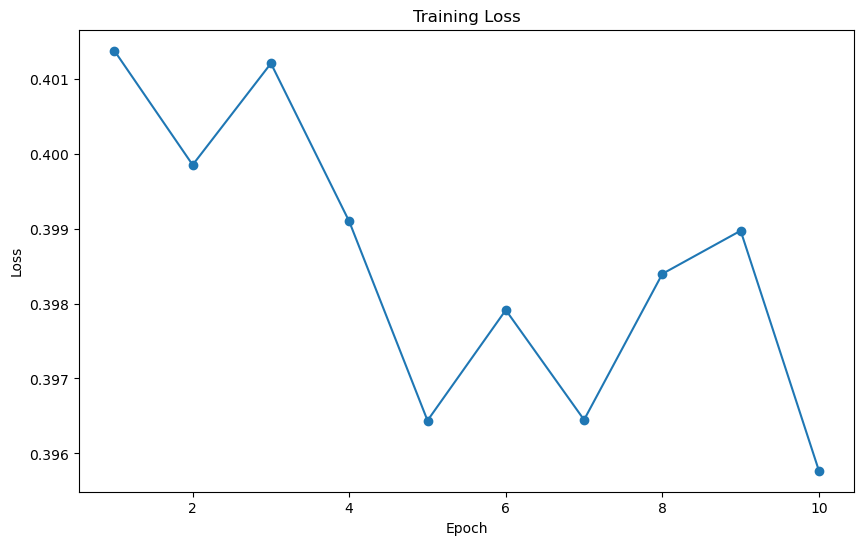

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()